# BASED OF
- https://github.com/CamDavidsonPilon/Probabilistic-Programming-and-Bayesian-Methods-for-Hackers


found from
- https://nbviewer.jupyter.org/github/CamDavidsonPilon/Probabilistic-Programming-and-Bayesian-Methods-for-Hackers/blob/master/Chapter1_Introduction/Ch1_Introduction_PyMC2.ipynb

## Updating probability based on coin flips 
- Note only large values converge towards 0

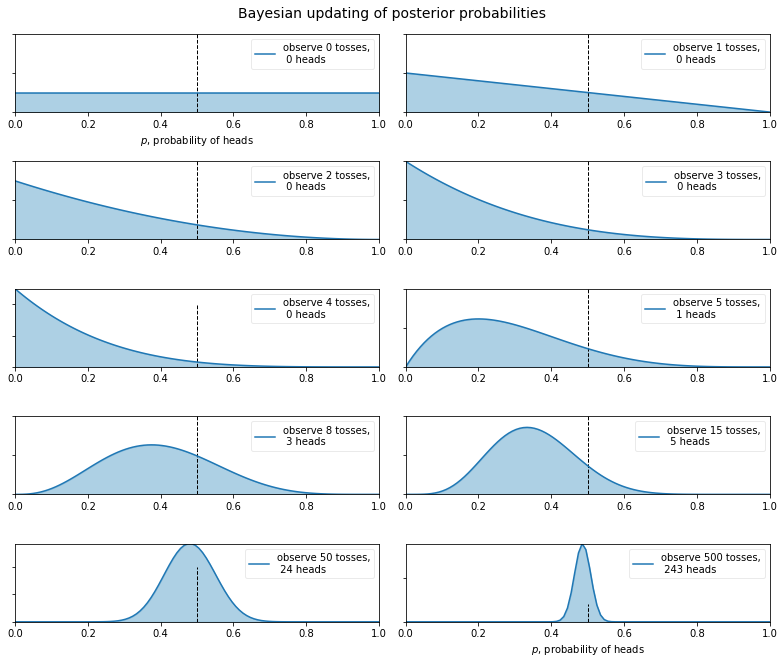

In [5]:
# The code below can be passed over, as it is currently not important, plus it
# uses advanced topics we have not covered yet. LOOK AT PICTURE, MICHAEL!
%matplotlib inline
from IPython.core.pylabtools import figsize
import numpy as np
from matplotlib import pyplot as plt
figsize(11, 9)

import scipy.stats as stats

dist = stats.beta
n_trials = [0, 1, 2, 3, 4, 5, 8, 15, 50, 500]
data = stats.bernoulli.rvs(0.5, size=n_trials[-1])
x = np.linspace(0, 1, 100)

# For the already prepared, I'm using Binomial's conj. prior.
for k, N in enumerate(n_trials):
    sx = plt.subplot(len(n_trials) / 2, 2, k + 1)
    plt.xlabel("$p$, probability of heads") \
        if k in [0, len(n_trials) - 1] else None
    plt.setp(sx.get_yticklabels(), visible=False)
    heads = data[:N].sum()
    y = dist.pdf(x, 1 + heads, 1 + N - heads)
    plt.plot(x, y, label="observe %d tosses,\n %d heads" % (N, heads))
    plt.fill_between(x, 0, y, color="#348ABD", alpha=0.4)
    plt.vlines(0.5, 0, 4, color="k", linestyles="--", lw=1)

    leg = plt.legend()
    leg.get_frame().set_alpha(0.4)
    plt.autoscale(tight=True)


plt.suptitle("Bayesian updating of posterior probabilities",
             y=1.02,
             fontsize=14)

plt.tight_layout()

# Discrete poisson

$$ P(Z=k)=\frac{\lambda^k e^{−\lambda}}{k!},k=0,1,2,\ldots, \lambda \in \mathbb{R} >0 $$

Expected value (mean over converged mean)
$$ E[Z|\lambda]= \lambda $$

Text(0.5, 1.0, 'Probability mass function of a Poisson random variable; differing $\\lambda$ values')

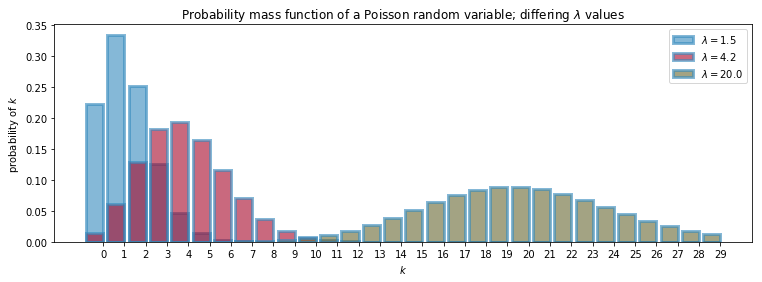

In [7]:
figsize(12.5, 4)

import scipy.stats as stats
a = np.arange(30)
poi = stats.poisson
lambda_ = [1.5, 4.25, 20]
colours = ["#348ABD", "#A60628","#666630"]

for l,c in zip(lambda_, colours):
    plt.bar(a, poi.pmf(a, l), color=c,
        label="$\lambda = %.1f$" % l, alpha=0.60,
        edgecolor=colours[0], lw="3")

# plt.bar(a, poi.pmf(a, lambda_[1]), color=colours[1],
#         label="$\lambda = %.1f$" % lambda_[1], alpha=0.60,
#         edgecolor=colours[1], lw="3")

plt.xticks(a + 0.4, a)
plt.legend()
plt.ylabel("probability of $k$")
plt.xlabel("$k$")
plt.title("Probability mass function of a Poisson random variable; differing \
$\lambda$ values")

# Continous expoential

$$ f_Z(z|\lambda)=\lambda e^{−\lambda z},z \geq 0 $$

Expected value:
$$ E[Z|\lambda ]=\frac{1}{\lambda} $$

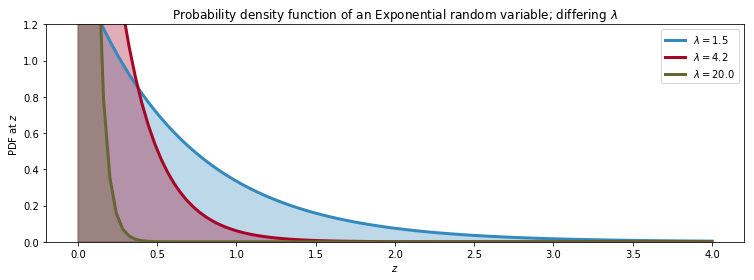

In [10]:
a = np.linspace(0, 4, 100)
expo = stats.expon
lambda_ = [1.5, 4.25, 20]
colours = ["#348ABD", "#A60628","#666630"]

for l, c in zip(lambda_, colours):
    plt.plot(a, expo.pdf(a, scale=1./ l), lw=3,
             color=c, label="$\lambda = %.1f$" % l)
    plt.fill_between(a, expo.pdf(a, scale=1. / l), color=c, alpha=.33)

plt.legend()
plt.ylabel("PDF at $z$")
plt.xlabel("$z$")
plt.ylim(0, 1.2)
plt.title("Probability density function of an Exponential random variable;\
 differing $\lambda$");

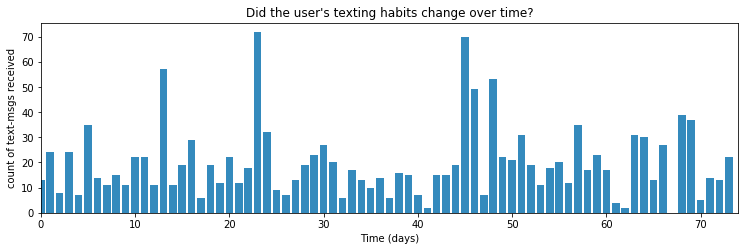

In [6]:
figsize(12.5, 3.5)
count_data = np.loadtxt("../data/txtdata.csv")
n_count_data = len(count_data)
plt.bar(np.arange(n_count_data), count_data, color="#348ABD")
plt.xlabel("Time (days)")
plt.ylabel("count of text-msgs received")
plt.title("Did the user's texting habits change over time?")
plt.xlim(0, n_count_data);

In [10]:
import pymc3 as pm
import theano.tensor as tt

with pm.Model() as model:
    alpha = 1.0/count_data.mean()  # Recall count_data is the
                                   # variable that holds our txt counts
    lambda_1 = pm.Exponential("lambda_1", alpha)
    lambda_2 = pm.Exponential("lambda_2", alpha)
    
    tau = pm.DiscreteUniform("tau", lower=0, upper=n_count_data - 1)

    

In [12]:
with model:
    idx = np.arange(n_count_data) # Index
    lambda_ = pm.math.switch(tau > idx, lambda_1, lambda_2)

In [13]:
with model:
    observation = pm.Poisson("obs", lambda_, observed=count_data)

In [14]:
with model:
    step = pm.Metropolis()
    trace = pm.sample(10000, tune=5000,step=step)

Multiprocess sampling (4 chains in 4 jobs)
CompoundStep
>Metropolis: [tau]
>Metropolis: [lambda_2]
>Metropolis: [lambda_1]
Sampling 4 chains: 100%|██████████| 60000/60000 [00:09<00:00, 6052.23draws/s]
The number of effective samples is smaller than 25% for some parameters.


In [15]:
lambda_1_samples = trace['lambda_1']
lambda_2_samples = trace['lambda_2']
tau_samples = trace['tau']

/Users/epedersen/.pyenv/versions/3.7.0/lib/python3.7/site-packages/matplotlib/axes/_axes.py:6521: MatplotlibDeprecationWarning: 
The 'normed' kwarg was deprecated in Matplotlib 2.1 and will be removed in 3.1. Use 'density' instead.
  alternative="'density'", removal="3.1")


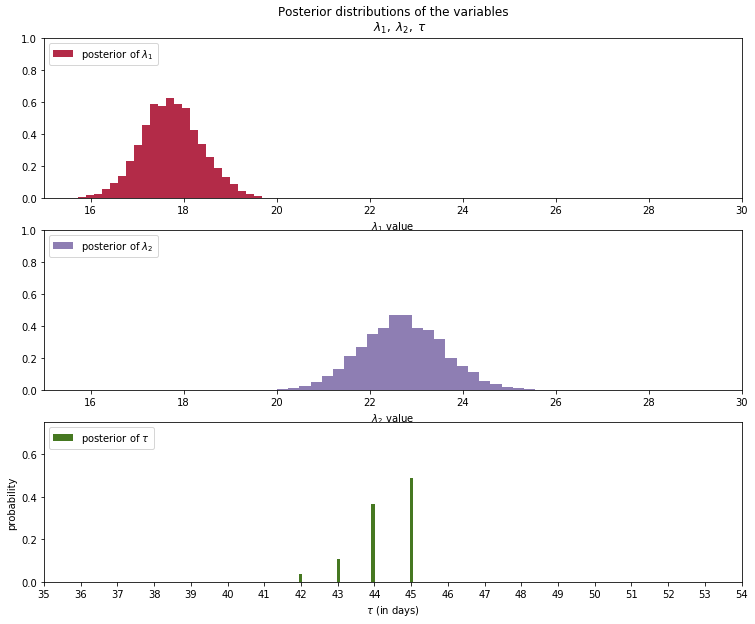

In [16]:
figsize(12.5, 10)
#histogram of the samples:

ax = plt.subplot(311)
ax.set_autoscaley_on(False)

plt.hist(lambda_1_samples, histtype='stepfilled', bins=30, alpha=0.85,
         label="posterior of $\lambda_1$", color="#A60628", normed=True)
plt.legend(loc="upper left")
plt.title(r"""Posterior distributions of the variables
    $\lambda_1,\;\lambda_2,\;\tau$""")
plt.xlim([15, 30])
plt.xlabel("$\lambda_1$ value")

ax = plt.subplot(312)
ax.set_autoscaley_on(False)
plt.hist(lambda_2_samples, histtype='stepfilled', bins=30, alpha=0.85,
         label="posterior of $\lambda_2$", color="#7A68A6", normed=True)
plt.legend(loc="upper left")
plt.xlim([15, 30])
plt.xlabel("$\lambda_2$ value")

plt.subplot(313)
w = 1.0 / tau_samples.shape[0] * np.ones_like(tau_samples)
plt.hist(tau_samples, bins=n_count_data, alpha=1,
         label=r"posterior of $\tau$",
         color="#467821", weights=w, rwidth=2.)
plt.xticks(np.arange(n_count_data))

plt.legend(loc="upper left")
plt.ylim([0, .75])
plt.xlim([35, len(count_data)-20])
plt.xlabel(r"$\tau$ (in days)")
plt.ylabel("probability");

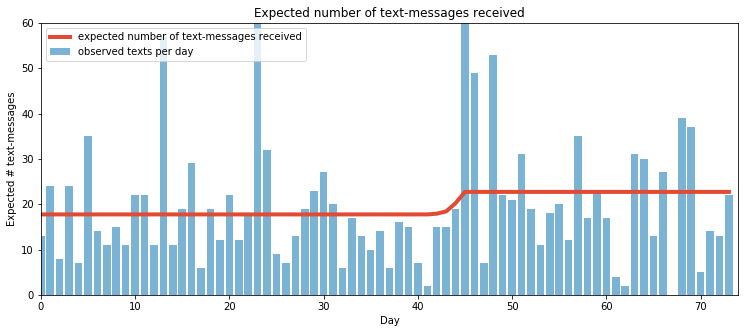

In [17]:
figsize(12.5, 5)
# tau_samples, lambda_1_samples, lambda_2_samples contain
# N samples from the corresponding posterior distribution
N = tau_samples.shape[0]
expected_texts_per_day = np.zeros(n_count_data)
for day in range(0, n_count_data):
    # ix is a bool index of all tau samples corresponding to
    # the switchpoint occurring prior to value of 'day'
    ix = day < tau_samples
    # Each posterior sample corresponds to a value for tau.
    # for each day, that value of tau indicates whether we're "before"
    # (in the lambda1 "regime") or
    #  "after" (in the lambda2 "regime") the switchpoint.
    # by taking the posterior sample of lambda1/2 accordingly, we can average
    # over all samples to get an expected value for lambda on that day.
    # As explained, the "message count" random variable is Poisson distributed,
    # and therefore lambda (the poisson parameter) is the expected value of
    # "message count".
    expected_texts_per_day[day] = (lambda_1_samples[ix].sum()
                                   + lambda_2_samples[~ix].sum()) / N


plt.plot(range(n_count_data), expected_texts_per_day, lw=4, color="#E24A33",
         label="expected number of text-messages received")
plt.xlim(0, n_count_data)
plt.xlabel("Day")
plt.ylabel("Expected # text-messages")
plt.title("Expected number of text-messages received")
plt.ylim(0, 60)
plt.bar(np.arange(len(count_data)), count_data, color="#348ABD", alpha=0.65,
        label="observed texts per day")

plt.legend(loc="upper left");

## Exercises

1\.  Using `lambda_1_samples` and `lambda_2_samples`, what is the mean of the posterior distributions of $\lambda_1$ and $\lambda_2$?

In [28]:
display("L1_avg = %.3f | L2_avg = %.3f " % (
lambda_1_samples.mean(),
lambda_2_samples.mean()))


'L1_avg = 17.744 | L2_avg = 22.714 '

2\.  What is the expected percentage increase in text-message rates? `hint:` compute the mean of `lambda_1_samples/lambda_2_samples`. Note that this quantity is very different from `lambda_1_samples.mean()/lambda_2_samples.mean()`.

In [40]:
print("Correct")
print(np.mean(lambda_1_samples/lambda_2_samples))

print("----\nAVG. ratio")
print(lambda_1_samples.mean()/lambda_2_samples.mean())


Correct
0.782411879786092
----
AVG. ratio
0.7812183131697572


3. What is the mean of  𝜆1  given that we know  𝜏  is less than 45. That is, suppose we have been given new information that the change in behaviour occurred prior to day 45. What is the expected value of  𝜆1  now? (You do not need to redo the PyMC3 part. Just consider all instances where tau_samples < 45.)

In [41]:
print(np.mean(lambda_1_samples))
print(np.mean(lambda_1_samples[tau_samples<45]))

17.744364104266552
17.74940187764473


In [46]:
a = list(range(20))
a[5::2]

[5, 7, 9, 11, 13, 15, 17, 19]